# StackSMART
## Develop app to help users predict waiting time to get answers on Stack Overflow
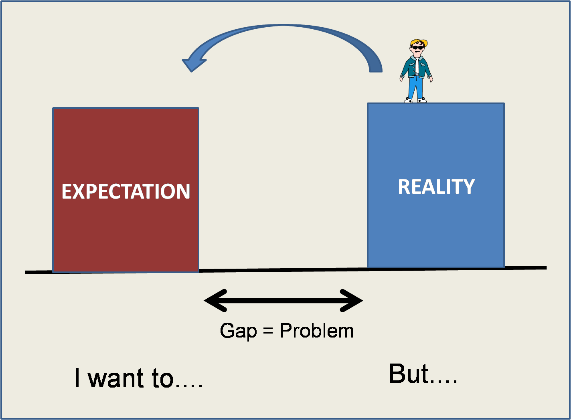

## Data
#### Stack Exchange DataDump: https://archive.org/download/stackexchange
#### Stanford University SNAP Network Datasets: http://snap.stanford.edu/data/sx-stackoverflow.html
## Features
#### Post Characteristics: Language used, length of post, tags
#### User Network Characteristics
#### Others: Time of posting

## Model
#### Combination of Linear Regression and Random Forest

## Prediction Result (Mean Absolute Error: 0.83, R Squared: 0.83)
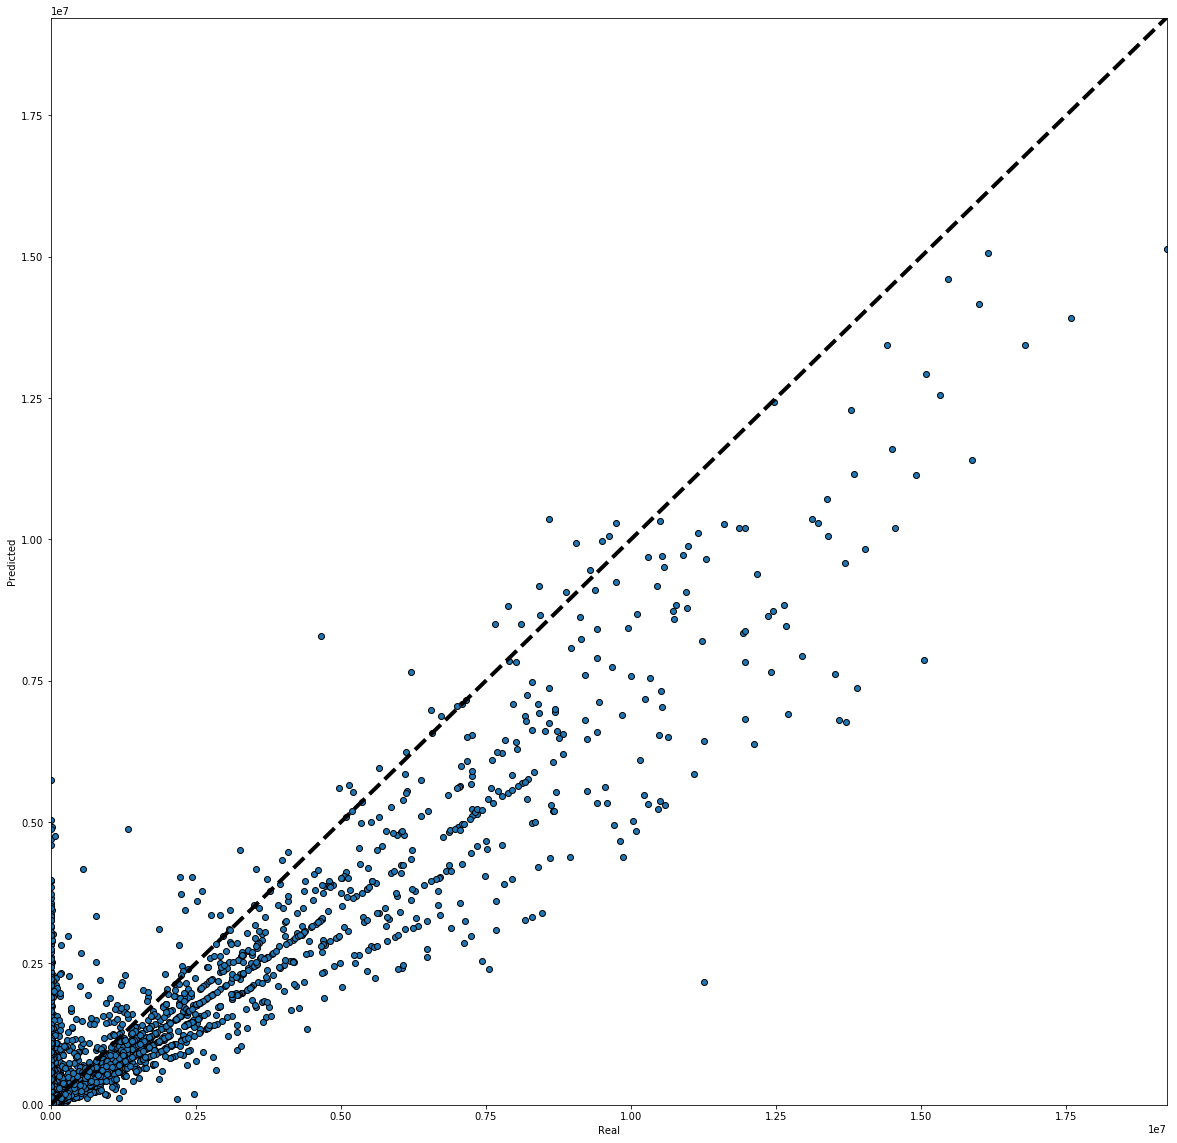

## Top 40 Words that Increase or Decrease Waiting Time
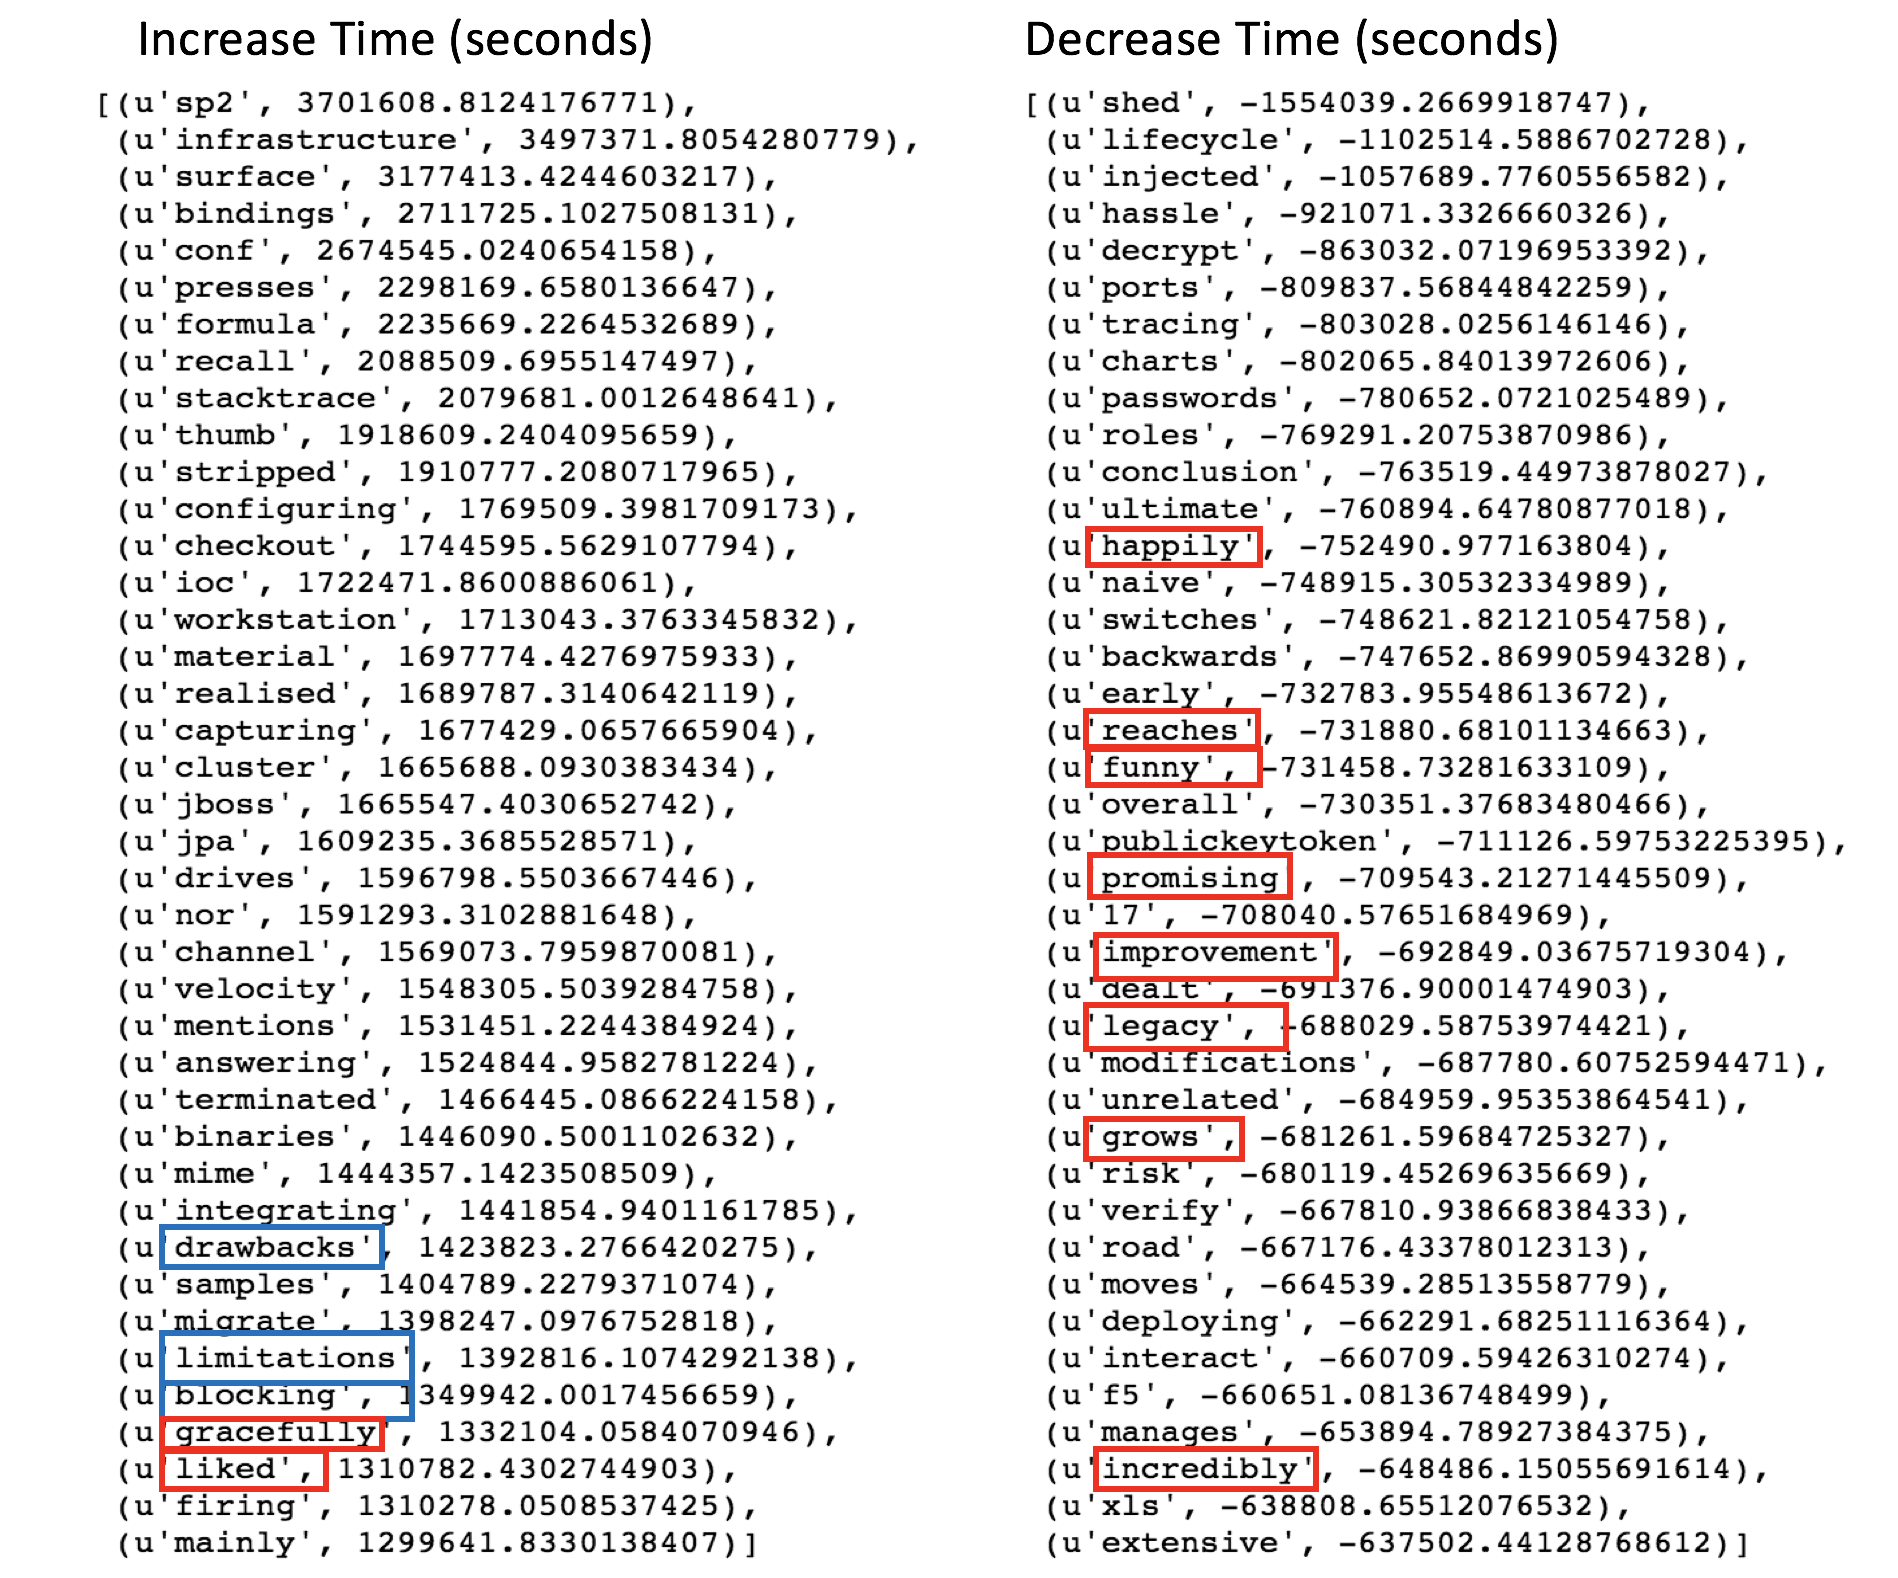